# GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [2]:
import os 
import requests
from zipfile import ZipFile 
import shutil #para copiar las imagenes de FER2013 y CK a data
import pandas as pd #para crear dataframe
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split #dividir la data de train en train ,test y val
from collections import Counter #para contar la cantidad de labels de cada generador
from keras.preprocessing.image import ImageDataGenerator #para crear el generador e iterador por dataframe o directory(), además pre-processing
import numpy as np 
import matplotlib.pyplot as plt #Gráficar
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint #para crear un punto de control y guardar cada acc en cada epochs que mejore
from datetime import datetime #para tensorboard
from tensorflow.keras.callbacks import TensorBoard #para tensorboard
from keras.applications import InceptionResNetV2 
from keras.models import Sequential, Model 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D 
import PIL

from keras.applications import EfficientNetB0
from keras.layers import BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D, Input
from keras.models import Model
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight

from keras.applications import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D, Flatten,GaussianNoise, BatchNormalization, Conv2D, Input
from tensorflow.keras.optimizers import Adam,SGD
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, LearningRateScheduler
import math

In [3]:
import random, os
import numpy as np
#import tensorflow as tf

def set_seed(seed=42):
  np.random.seed(seed) 
  tf.random.set_seed(seed) 
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Copy the images of train and test in a new folder

In [6]:
data_dir = 'fer2013/train' #se define la ubicación de la carpeta de los datos
filepath = [] #se define la lista donde van a estar todas las ubicaciones de cada imagen
labels = [] #se define la lista donde va a estar todos los labels
classes = os.listdir(data_dir) #lista las clases

for classfolder in classes: #por cada clase
    folderclass = os.path.join(data_dir, classfolder) #obtiene la ruta
    file_list = os.listdir(folderclass) #ingresa y los lista
    for files in file_list: #por cada archivo dentro de las clases
      pathfile = os.path.join(folderclass,files) #obtiene la ruta
      filepath.append(pathfile) #ingresa el path del file en filepath
      labels.append(classfolder) #ingresa el labels del file en labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Se crea un dataframe que tenga una columna llamada filepath, donde va a tener la lista de las ubicaciones de las imagenes
#Se crea una columna llamada labels que va a tener la lista de los labels de cada file (filepath)
# Dividir los datos en entrenamiento y validación (80% - 20%) usando stratify
train_df, val_df = train_test_split(datos, test_size=0.2, random_state=42, stratify=datos['labels'])

# Directorios de salida
output_dir = 'datosBalancingWithDataAugmentation'
new_train_folder = os.path.join(output_dir, 'train')
new_val_folder = os.path.join(output_dir, 'val')

# Crear las carpetas de salida si no existen
os.makedirs(new_train_folder, exist_ok=True)
os.makedirs(new_val_folder, exist_ok=True)

# Mover archivos de entrenamiento a la nueva carpeta de entrenamiento
for _, row in train_df.iterrows():
    label = row['labels']
    src_path = row['filepath']
    dst_folder = os.path.join(new_train_folder, label)
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(src_path, dst_folder)

# Mover archivos de validación a la nueva carpeta de validación
for _, row in val_df.iterrows():
    label = row['labels']
    src_path = row['filepath']
    dst_folder = os.path.join(new_val_folder, label)
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(src_path, dst_folder)

# Copiar la carpeta 'test' directamente
test_src_folder = os.path.join('fer2013', 'test')
test_dst_folder = os.path.join(output_dir, 'test')
if os.path.exists(test_src_folder):
    shutil.copytree(test_src_folder, test_dst_folder)

In [12]:
train_df

,filepath,labels
4927,fer2013/train\fear\Training_21644135.jpg,fear
7850,fer2013/train\fear\Training_85697399.jpg,fear
3111,fer2013/train\angry\Training_80724752.jpg,angry
14742,fer2013/train\happy\Training_8750576.jpg,happy
16096,fer2013/train\neutral\Training_16088401.jpg,neutral
...,...,...
4850,fer2013/train\fear\Training_19944949.jpg,fear
3952,fer2013/train\angry\Training_99201757.jpg,angry
8732,fer2013/train\happy\Training_12347448.jpg,happy
11277,fer2013/train\happy\Training_44243624.jpg,happy


In [13]:
train_df['labels'].value_counts()

labels
happy       5772
neutral     3972
sad         3864
fear        3277
angry       3196
surprise    2537
disgust      349
Name: count, dtype: int64

In [14]:
val_df

,filepath,labels
20243,fer2013/train\neutral\Training_91712654.jpg,neutral
23266,fer2013/train\sad\Training_57347276.jpg,sad
4148,fer2013/train\disgust\Training_43986935.jpg,disgust
3108,fer2013/train\angry\Training_80694454.jpg,angry
6386,fer2013/train\fear\Training_54053151.jpg,fear
...,...,...
23056,fer2013/train\sad\Training_53510918.jpg,sad
10716,fer2013/train\happy\Training_3699660.jpg,happy
18447,fer2013/train\neutral\Training_58581958.jpg,neutral
16908,fer2013/train\neutral\Training_30460757.jpg,neutral


In [15]:
data_dir = 'fer2013/train' #se define la ubicación de la carpeta de los datos
filepath = [] #se define la lista donde van a estar todas las ubicaciones de cada imagen
labels = [] #se define la lista donde va a estar todos los labels
classes = os.listdir(data_dir) #lista las clases

for classfolder in classes: #por cada clase
    folderclass = os.path.join(data_dir, classfolder) #obtiene la ruta
    file_list = os.listdir(folderclass) #ingresa y los lista
    for files in file_list: #por cada archivo dentro de las clases
      pathfile = os.path.join(folderclass,files) #obtiene la ruta
      filepath.append(pathfile) #ingresa el path del file en filepath
      labels.append(classfolder) #ingresa el labels del file en labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Se crea un dataframe que tenga una columna llamada filepath, donde va a tener la lista de las ubicaciones de las imagenes
#Se crea una columna llamada labels que va a tener la lista de los labels de cada file (filepath)

In [16]:
datos

,filepath,labels
0,fer2013/train\angry\Training_10118481.jpg,angry
1,fer2013/train\angry\Training_10120469.jpg,angry
2,fer2013/train\angry\Training_10131352.jpg,angry
3,fer2013/train\angry\Training_10161559.jpg,angry
4,fer2013/train\angry\Training_1021836.jpg,angry
...,...,...
28704,fer2013/train\surprise\Training_99916297.jpg,surprise
28705,fer2013/train\surprise\Training_99924420.jpg,surprise
28706,fer2013/train\surprise\Training_99937001.jpg,surprise
28707,fer2013/train\surprise\Training_99951755.jpg,surprise


In [17]:
datos['labels'].value_counts()

labels
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

# Data balancing through data augmentation in the training set

In [18]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


data_dir = 'datosBalancingWithDataAugmentation/train'

# La lista de las clases
classes = os.listdir(data_dir)

# Se balancea a 5.772 cada clase
max_images_per_class = 5772

# Parámetros de Data Augmentation leves para el Oversampling
datagen = ImageDataGenerator(
    rotation_range=2,  # Rango de rotación
    width_shift_range=0.02,  # Rango de desplazamiento horizontal 
    height_shift_range=0.02,  # Rango de desplazamiento vertical
    zoom_range=0.02,  # Rango de zoom
)

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_dir))
    
    # Aplicar Data Augmentation solo a las clases minoritarias
    if num_images < max_images_per_class: #Si el numero de imagenes de la clase es menor que 5.772
        print(f"Aplicando Data Augmentation a la clase: {class_name}")
        images_needed = max_images_per_class - num_images
        print(images_needed)

    while len(os.listdir(class_dir)) < max_images_per_class: #Que se aplique mientras la cantidad sea menor a 8.500
        for img_file in os.listdir(class_dir):
            if (len(os.listdir(class_dir)) == max_images_per_class): #si son iguales que salga
                break
            img_path = os.path.join(class_dir, img_file)
            
            # Cargar la imagen
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            
            # Mediante batch de 1 imagen se va generando nuevas imagenes con las transformaciones y guardando en el mismo directorio
            for batch in datagen.flow(x, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpg'):
                break


Aplicando Data Augmentation a la clase: angry
2576
Aplicando Data Augmentation a la clase: disgust
5423
Aplicando Data Augmentation a la clase: fear
2495
Aplicando Data Augmentation a la clase: neutral
1800
Aplicando Data Augmentation a la clase: sad
1908
Aplicando Data Augmentation a la clase: surprise
3235


In [19]:
data_dir = 'datosBalancingWithDataAugmentation/train' #se define la ubicación de la carpeta de los datos
filepath = [] #se define la lista donde van a estar todas las ubicaciones de cada imagen
labels = [] #se define la lista donde va a estar todos los labels
classes = os.listdir(data_dir) #lista las clases

for classfolder in classes: #por cada clase
    folderclass = os.path.join(data_dir, classfolder) #obtiene la ruta
    file_list = os.listdir(folderclass) #ingresa y los lista
    for files in file_list: #por cada archivo dentro de las clases
      pathfile = os.path.join(folderclass,files) #obtiene la ruta
      filepath.append(pathfile) #ingresa el path del file en filepath
      labels.append(classfolder) #ingresa el labels del file en labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Se crea un dataframe que tenga una columna llamada filepath, donde va a tener la lista de las ubicaciones de las imagenes
#Se crea una columna llamada labels que va a tener la lista de los labels de cada file (filepath)

In [20]:
datos['labels'].value_counts()

labels
angry       5772
disgust     5772
fear        5772
happy       5772
neutral     5772
sad         5772
surprise    5772
Name: count, dtype: int64

# Data Augmentation

In [21]:
img_shape = 48
batch_size = 64

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'datosBalancingWithDataAugmentation/train'
val_dir = 'datosBalancingWithDataAugmentation/val'
test_dir = 'datosBalancingWithDataAugmentation/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,                
    rotation_range=8,            
    zoom_range=0.2,               
    width_shift_range=0.1,        
    height_shift_range=0.1,           
    horizontal_flip=True,         
    fill_mode='nearest'                  
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,           
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)




#classes = np.array(train_generator.classes)


#class_weights = compute_class_weight(
#    class_weight='balanced',  
#    classes=np.unique(classes),  
#    y=classes  
#)


#class_weights_dict = dict(enumerate(class_weights))

#print("Class Weights Dictionary:", class_weights_dict)

Found 40404 images belonging to 7 classes.
Found 5742 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
print("Cantidad de imágenes por clase en el conjunto de entrenamiento:")
for cls, idx in train_generator.class_indices.items():
    print(f"{cls}: {sum(train_generator.classes == idx)}")

print("\nCantidad de imágenes por clase en el conjunto de validación:")
for cls, idx in val_generator.class_indices.items():
    print(f"{cls}: {sum(val_generator.classes == idx)}")

print("\nCantidad de imágenes por clase en el conjunto de prueba:")
for cls, idx in test_generator.class_indices.items():
    print(f"{cls}: {sum(test_generator.classes == idx)}")

Cantidad de imágenes por clase en el conjunto de entrenamiento:
angry: 5772
disgust: 5772
fear: 5772
happy: 5772
neutral: 5772
sad: 5772
surprise: 5772

Cantidad de imágenes por clase en el conjunto de validación:
angry: 799
disgust: 87
fear: 820
happy: 1443
neutral: 993
sad: 966
surprise: 634

Cantidad de imágenes por clase en el conjunto de prueba:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


# Models

## Model 1 66.99%

In [103]:
import tensorflow as tf
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [104]:
model_MoreData = tf.keras.Sequential([

        
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,3)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(7, activation='softmax')
    ])

In [105]:
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_MoreData.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_MoreData.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 conv2d_22 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_14 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 23, 23, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 23, 23, 128)      

In [106]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test1_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test1_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test1_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [108]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [109]:
historytest1_MoreData = model_MoreData.fit(x = train_generator,epochs = 300,validation_data = val_generator, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 9.4685 - accuracy: 0.2137
Epoch 1: val_accuracy improved from -inf to 0.25670, saving model to models2DataAugmentation/test1_MoreData/64batch\best_model_ModelPaper2_1_0.2567.h5
632/632 [==============================] - 125s 192ms/step - loss: 9.4685 - accuracy: 0.2137 - val_loss: 8.9821 - val_accuracy: 0.2567 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 7.9592 - accuracy: 0.2772
Epoch 2: val_accuracy improved from 0.25670 to 0.31017, saving model to models2DataAugmentation/test1_MoreData/64batch\best_model_ModelPaper2_2_0.3102.h5
632/632 [==============================] - 75s 119ms/step - loss: 7.9592 - accuracy: 0.2772 - val_loss: 7.1363 - val_accuracy: 0.3102 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 6.5583 - accuracy: 0.3181
Epoch 3: val_accuracy improved from 0.31017 to 0.33403, saving model to models2DataAugmentation/test1

In [133]:
model_MoreData.save('models2DataAugmentation/test1_MoreData/64batch/best_model_ModelPaper2_72_best_test.h5')

In [110]:
model_MoreData.evaluate(test_generator)

113/113 [==============================] - 9s 77ms/step - loss: 1.2211 - accuracy: 0.6700


[1.2211298942565918, 0.6699637770652771]

In [132]:
model_eval1 = tf.keras.models.load_model(r'models2DataAugmentation/test1_MoreData/64batch\best_model_ModelPaper2_71_0.6721.h5')
eval1 = model_eval1.evaluate(test_generator)
print(eval1)

113/113 [==============================] - 5s 40ms/step - loss: 1.2272 - accuracy: 0.6694
[1.2271623611450195, 0.669406533241272]


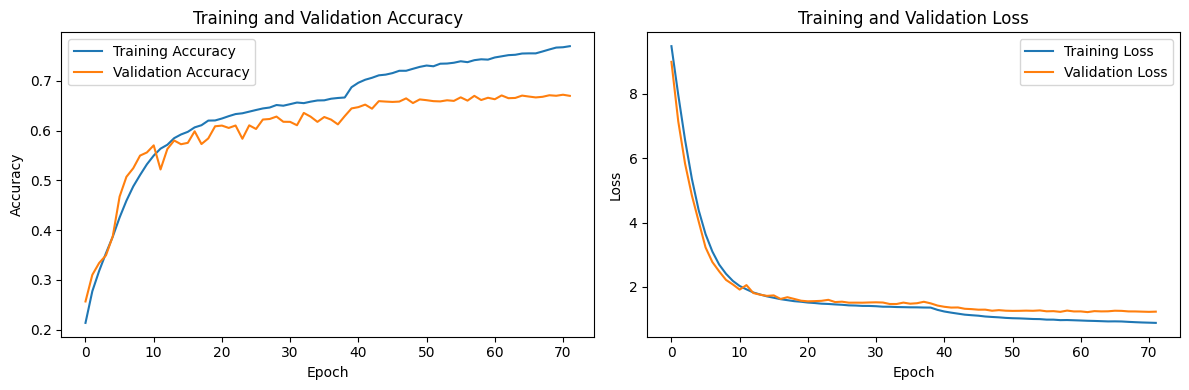

In [111]:
import matplotlib.pyplot as plt


accuracy = historytest1_MoreData.history['accuracy']
loss = historytest1_MoreData.history['loss']
val_accuracy = historytest1_MoreData.history['val_accuracy']
val_loss = historytest1_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 2 67.62%

In [112]:
model8_MoreData = tf.keras.models.Sequential()   

model8_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(2, 2))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Flatten())
model8_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData.add(Dropout(0.5))
    
model8_MoreData.add(Dense(7, activation='softmax'))


model8_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [113]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test8_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test8_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test8_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test8_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [114]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [115]:
historytest8_MoreData = model8_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 20.6776 - accuracy: 0.2201
Epoch 1: val_accuracy improved from -inf to 0.31888, saving model to models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_1_0.3189.h5
632/632 [==============================] - 73s 113ms/step - loss: 20.6776 - accuracy: 0.2201 - val_loss: 16.4027 - val_accuracy: 0.3189 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 12.6226 - accuracy: 0.3194
Epoch 2: val_accuracy did not improve from 0.31888
632/632 [==============================] - 71s 112ms/step - loss: 12.6226 - accuracy: 0.3194 - val_loss: 9.6982 - val_accuracy: 0.3175 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 7.6481 - accuracy: 0.3580
Epoch 3: val_accuracy improved from 0.31888 to 0.40387, saving model to models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_3_0.4039.h5
632/632 [==============================] - 72s

In [134]:
model_eval2 = tf.keras.models.load_model(r'models2DataAugmentation/test8_MoreData/64batch\best_model_ModelPaper2_63_0.6735.h5')
eval1 = model_eval2.evaluate(test_generator)
print(eval1)

113/113 [==============================] - 5s 43ms/step - loss: 1.1128 - accuracy: 0.6762
[1.1128361225128174, 0.6762329339981079]


In [116]:
model8_MoreData.evaluate(test_generator)

113/113 [==============================] - 6s 53ms/step - loss: 1.1128 - accuracy: 0.6762


[1.1128361225128174, 0.6762329339981079]

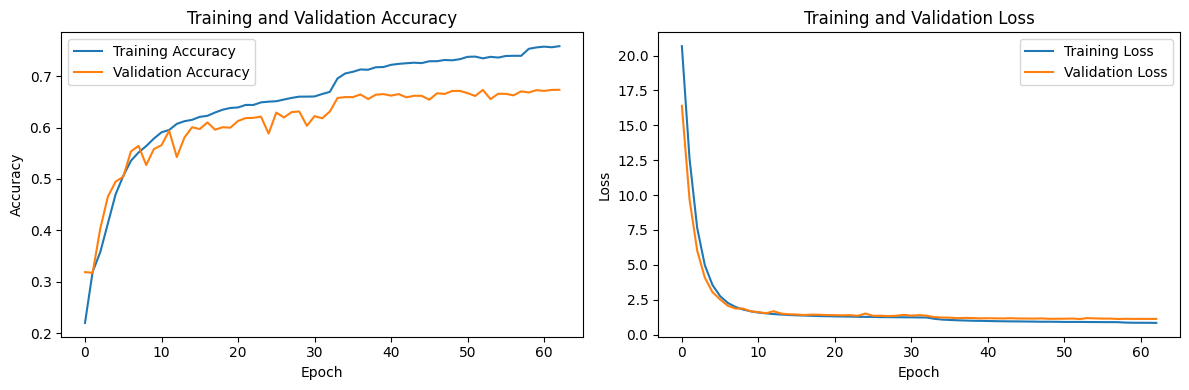

In [117]:
import matplotlib.pyplot as plt


accuracy = historytest8_MoreData.history['accuracy']
loss = historytest8_MoreData.history['loss']
val_accuracy = historytest8_MoreData.history['val_accuracy']
val_loss = historytest8_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 3 66.03%

In [118]:
model6_MoreData = tf.keras.models.Sequential()   

model6_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model6_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model6_MoreData.add(BatchNormalization())
model6_MoreData.add(MaxPooling2D(2, 2))
model6_MoreData.add(Dropout(0.3))

model6_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model6_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model6_MoreData.add(BatchNormalization())
model6_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model6_MoreData.add(Dropout(0.3))

model6_MoreData.add(Flatten())
model6_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model6_MoreData.add(Dropout(0.5))
    
model6_MoreData.add(Dense(7, activation='softmax'))

model6_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [119]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test6_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test6_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test6_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test6_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [120]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [121]:
historytest6_MoreData = model6_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 17.1165 - accuracy: 0.2348
Epoch 1: val_accuracy improved from -inf to 0.34222, saving model to models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_1_0.3422.h5
632/632 [==============================] - 92s 145ms/step - loss: 17.1165 - accuracy: 0.2348 - val_loss: 10.2075 - val_accuracy: 0.3422 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 6.8566 - accuracy: 0.3175
Epoch 2: val_accuracy improved from 0.34222 to 0.38558, saving model to models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_2_0.3856.h5
632/632 [==============================] - 99s 157ms/step - loss: 6.8566 - accuracy: 0.3175 - val_loss: 4.5744 - val_accuracy: 0.3856 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 3.7184 - accuracy: 0.3613
Epoch 3: val_accuracy did not improve from 0.38558
632/632 [==============================] - 77s 1

In [122]:
model6_MoreData.evaluate(test_generator)

113/113 [==============================] - 10s 83ms/step - loss: 1.1081 - accuracy: 0.6594


[1.108148455619812, 0.6593758463859558]

In [131]:
model6_MoreData1 = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_117_0.6609.h5')
eval = model6_MoreData1.evaluate(test_generator)
print(eval)

113/113 [==============================] - 4s 36ms/step - loss: 1.1128 - accuracy: 0.6604
[1.1128302812576294, 0.6603510975837708]


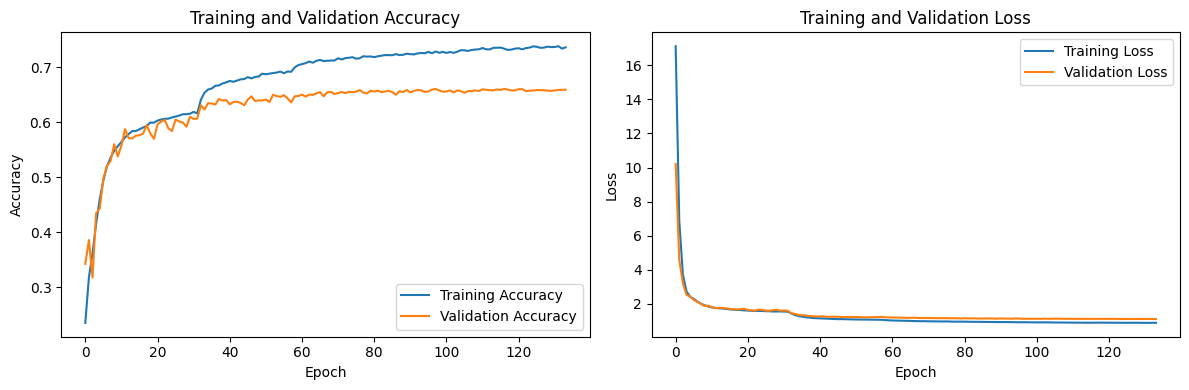

In [123]:
import matplotlib.pyplot as plt


accuracy = historytest6_MoreData.history['accuracy']
loss = historytest6_MoreData.history['loss']
val_accuracy = historytest6_MoreData.history['val_accuracy']
val_loss = historytest6_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 4 66.03%

In [124]:
from tensorflow.keras.applications import VGG16, ResNet50V2, VGG19
from keras.regularizers import l2
from keras.optimizers import Adamax



input_shape = (48, 48, 3)

base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)

model3_MoreData = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=1e-4)

model3_MoreData.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model3_MoreData.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_25 (Bat  (None, 1, 1, 512)        2048      
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)              

In [125]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test3_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test3_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test3_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test3_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [126]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [127]:
historytest3_MoreData = model3_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 2.2267 - accuracy: 0.3080
Epoch 1: val_accuracy improved from -inf to 0.33386, saving model to models2DataAugmentation/test3_MoreData/64batch\best_model_ModelPaper2_1_0.3339.h5
632/632 [==============================] - 99s 149ms/step - loss: 2.2267 - accuracy: 0.3080 - val_loss: 2.0804 - val_accuracy: 0.3339 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 1.8201 - accuracy: 0.4654
Epoch 2: val_accuracy improved from 0.33386 to 0.41205, saving model to models2DataAugmentation/test3_MoreData/64batch\best_model_ModelPaper2_2_0.4121.h5
632/632 [==============================] - 177s 281ms/step - loss: 1.8201 - accuracy: 0.4654 - val_loss: 1.9232 - val_accuracy: 0.4121 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 1.6156 - accuracy: 0.5262
Epoch 3: val_accuracy improved from 0.41205 to 0.46047, saving model to models2DataAugmentation/test3

In [130]:
model3_MoreData = tf.keras.models.load_model(r'models2DataAugmentation/test3_MoreData/64batch\best_model_ModelPaper2_23_0.6620.h5')
eval = model3_MoreData.evaluate(test_generator)
print(eval)

113/113 [==============================] - 26s 216ms/step - loss: 1.2358 - accuracy: 0.6604
[1.2357673645019531, 0.6603510975837708]


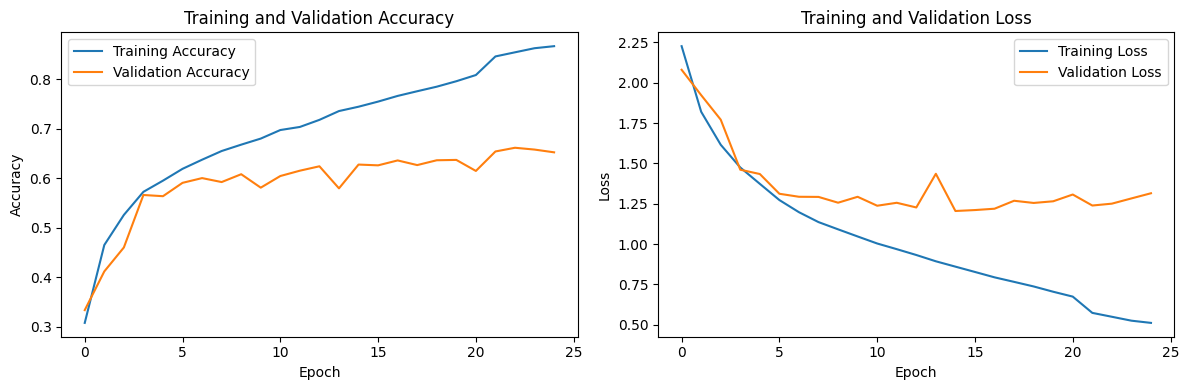

In [129]:
import matplotlib.pyplot as plt


accuracy = historytest3_MoreData.history['accuracy']
loss = historytest3_MoreData.history['loss']
val_accuracy = historytest3_MoreData.history['val_accuracy']
val_loss = historytest3_MoreData.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 5 53.99%

In [29]:
from keras.applications import ResNet50V2
ResNet =ResNet50V2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')
ResNet.summary()

ResNet.trainable=True

for layer in ResNet.layers[:-50]:
    layer.trainable = False

ResNet.summary()

x = Flatten()(ResNet.output)


x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  


output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

model4 = Model(inputs=ResNet.input, outputs=output)

model4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model4.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [28]:
from keras.callbacks import ReduceLROnPlateau


#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test4_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test4_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test4_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test4_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:
historytest3_MoreData4 = model4.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 1.8233 - accuracy: 0.3149
Epoch 1: val_accuracy improved from -inf to 0.40195, saving model to models2DataAugmentation/test4_MoreData/64batch\best_model_ModelPaper2_1_0.4020.h5
632/632 [==============================] - 127s 168ms/step - loss: 1.8233 - accuracy: 0.3149 - val_loss: 1.5382 - val_accuracy: 0.4020 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 1.4657 - accuracy: 0.4408
Epoch 2: val_accuracy improved from 0.40195 to 0.45925, saving model to models2DataAugmentation/test4_MoreData/64batch\best_model_ModelPaper2_2_0.4592.h5
632/632 [==============================] - 90s 142ms/step - loss: 1.4657 - accuracy: 0.4408 - val_loss: 1.4199 - val_accuracy: 0.4592 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 1.3379 - accuracy: 0.4917
Epoch 3: val_accuracy improved from 0.45925 to 0.48659, saving model to models2DataAugmentation/test4

In [35]:
model4.evaluate(test_generator)

113/113 [==============================] - 27s 238ms/step - loss: 1.2328 - accuracy: 0.5400


[1.2328038215637207, 0.5399832725524902]

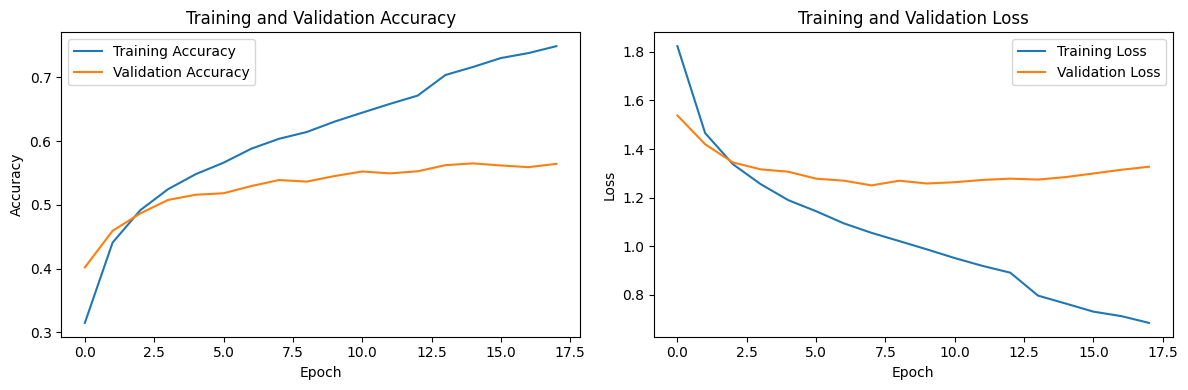

In [38]:
import matplotlib.pyplot as plt


accuracy = historytest3_MoreData4.history['accuracy']
loss = historytest3_MoreData4.history['loss']
val_accuracy = historytest3_MoreData4.history['val_accuracy']
val_loss = historytest3_MoreData4.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 6 65.82%

In [32]:
from keras.regularizers import L2
model15 = Sequential()

model15.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model15.add(BatchNormalization())
model15.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Flatten())
model15.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model15.add(Dropout(0.5))
model15.add(Dense(7, activation='softmax'))

model15.compile(optimizer=Adam(learning_rate=1e-4), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model15.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                      

In [33]:
from keras.callbacks import ReduceLROnPlateau


#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test5_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test5_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test5_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test5_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
historytest3_MoreData5 = model15.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 14.9802 - accuracy: 0.2104
Epoch 1: val_accuracy improved from -inf to 0.25792, saving model to models2DataAugmentation/test5_MoreData/64batch\best_model_ModelPaper2_1_0.2579.h5
632/632 [==============================] - 192s 300ms/step - loss: 14.9802 - accuracy: 0.2104 - val_loss: 11.0665 - val_accuracy: 0.2579 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 7.4794 - accuracy: 0.3088
Epoch 2: val_accuracy improved from 0.25792 to 0.32062, saving model to models2DataAugmentation/test5_MoreData/64batch\best_model_ModelPaper2_2_0.3206.h5
632/632 [==============================] - 90s 142ms/step - loss: 7.4794 - accuracy: 0.3088 - val_loss: 5.1165 - val_accuracy: 0.3206 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 3.7403 - accuracy: 0.3586
Epoch 3: val_accuracy improved from 0.32062 to 0.35650, saving model to models2DataAugmentation/te

In [39]:
model15_load =tf.keras.models.load_model(r'models2DataAugmentation/test5_MoreData/64batch\best_model_ModelPaper2_29_0.6630.h5')
model15_load.evaluate(test_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.0096 - accuracy: 0.6583


[1.0095502138137817, 0.6582613587379456]

In [37]:
model15.evaluate(test_generator)

113/113 [==============================] - 5s 45ms/step - loss: 1.0067 - accuracy: 0.6534


[1.0067260265350342, 0.65338534116745]

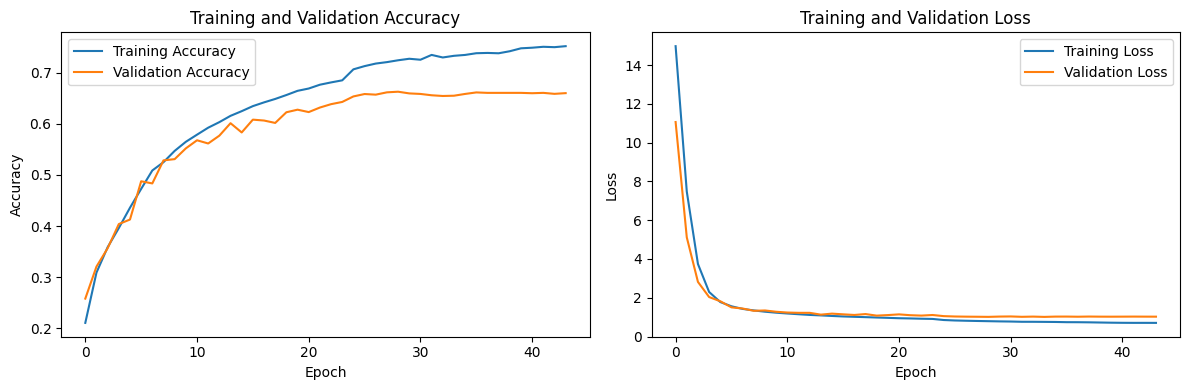

In [36]:
import matplotlib.pyplot as plt


accuracy = historytest3_MoreData5.history['accuracy']
loss = historytest3_MoreData5.history['loss']
val_accuracy = historytest3_MoreData5.history['val_accuracy']
val_loss = historytest3_MoreData5.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model 7 67.53%

In [40]:
model13 = tf.keras.models.Sequential()

model13.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model13.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(2, 2))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Flatten())
model13.add(Dense(2048, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))
model13.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))

model13.add(Dense(7, activation='softmax'))

model13.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [41]:
from keras.callbacks import ReduceLROnPlateau


#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models2DataAugmentation/test6_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models2DataAugmentation/test6_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs2DataAugmentation/test6_MoreData/64batch', exist_ok=True)



log_dir = "logs2DataAugmentation/test6_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
historytest3_MoreData6 = model13.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator,
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
632/632 [==============================] - ETA: 0s - loss: 38.7145 - accuracy: 0.1939
Epoch 1: val_accuracy improved from -inf to 0.27447, saving model to models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_1_0.2745.h5
632/632 [==============================] - 176s 275ms/step - loss: 38.7145 - accuracy: 0.1939 - val_loss: 27.5586 - val_accuracy: 0.2745 - lr: 1.0000e-04
Epoch 2/300
632/632 [==============================] - ETA: 0s - loss: 19.6670 - accuracy: 0.2823
Epoch 2: val_accuracy improved from 0.27447 to 0.30843, saving model to models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_2_0.3084.h5
632/632 [==============================] - 72s 114ms/step - loss: 19.6670 - accuracy: 0.2823 - val_loss: 13.4568 - val_accuracy: 0.3084 - lr: 1.0000e-04
Epoch 3/300
632/632 [==============================] - ETA: 0s - loss: 9.8696 - accuracy: 0.3521
Epoch 3: val_accuracy improved from 0.30843 to 0.38488, saving model to models2DataAugmentation

In [46]:
model13_load = tf.keras.models.load_model(r'models2DataAugmentation/test6_MoreData/64batch\best_model_ModelPaper2_69_0.6759.h5')
print(model13_load.evaluate(test_generator))

113/113 [==============================] - 5s 40ms/step - loss: 1.1241 - accuracy: 0.6754
[1.1241286993026733, 0.6753970384597778]


In [43]:
model13.evaluate(test_generator)

113/113 [==============================] - 10s 86ms/step - loss: 1.1201 - accuracy: 0.6743


[1.1201196908950806, 0.6742825508117676]

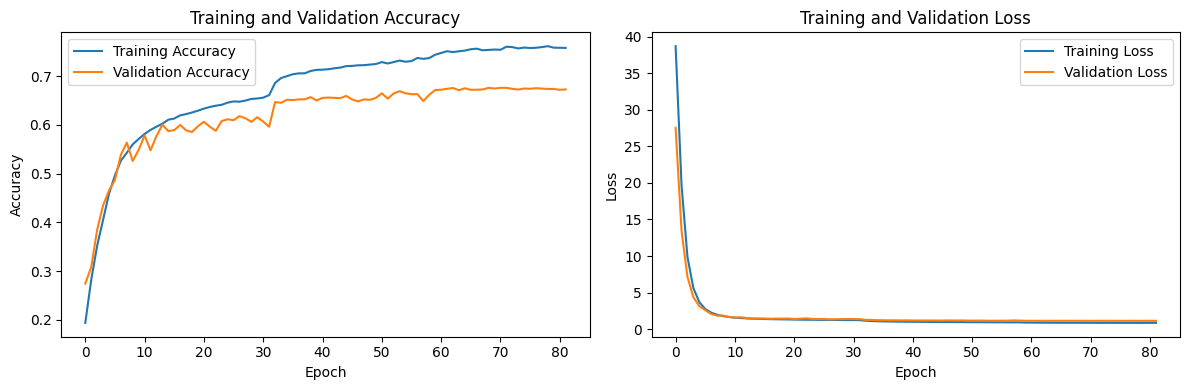

In [44]:
import matplotlib.pyplot as plt


accuracy = historytest3_MoreData6.history['accuracy']
loss = historytest3_MoreData6.history['loss']
val_accuracy = historytest3_MoreData6.history['val_accuracy']
val_loss = historytest3_MoreData6.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()